In [58]:
import helper
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms

In [42]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

### Load Data

In [43]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))])

In [44]:
train_set = datasets.FashionMNIST("../Data/", download=False, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

In [45]:
test_set = datasets.FashionMNIST("../Data/", download=False, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

### Building Model and Calculating Validation Loss

In [46]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        return x

In [47]:
images, labels = next(iter(test_loader))
prob = torch.exp(model(images))
prob.shape

torch.Size([64, 10])

In [48]:
top_prob, top_class = prob.topk(1, dim=1)
for i in range(5):
    print("{} : {}".format(top_prob[i], top_class[i]))

print(top_prob.shape)
print(top_class.shape)

tensor([1.0000], grad_fn=<SelectBackward>) : tensor([9])
tensor([0.9245], grad_fn=<SelectBackward>) : tensor([7])
tensor([0.5366], grad_fn=<SelectBackward>) : tensor([3])
tensor([0.9639], grad_fn=<SelectBackward>) : tensor([3])
tensor([0.7993], grad_fn=<SelectBackward>) : tensor([7])
torch.Size([64, 1])
torch.Size([64, 1])


In [49]:
equals = top_class == labels.view(*top_class.shape)

In [50]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print("Accuracy : {} %".format(accuracy.item() * 100))

Accuracy : 81.25 %


In [51]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [52]:
epochs = 10
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            for images, labels in test_loader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_ps, top_class = ps.topk(1, dim=1) 
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss / len(train_loader))
        test_losses.append(test_loss / len(test_loader))
        
        print("{}\n".format("-" * 50),
              "Epoch : {} / {}\n".format(e + 1, epochs),
              "Training loss : {}\n".format(running_loss / len(train_loader)),
              "Test loss : {}\n".format(test_loss / len(test_loader)),
              "Test Accuracy : {}\n".format(accuracy / len(test_loader)))

--------------------------------------------------
 Epoch : 1 / 10
 Training loss : 0.5300909760060595
 Test loss : 0.4734014570713043
 Test Accuracy : 0.8269307613372803

--------------------------------------------------
 Epoch : 2 / 10
 Training loss : 0.40956730841954886
 Test loss : 0.4523494243621826
 Test Accuracy : 0.8452428579330444

--------------------------------------------------
 Epoch : 3 / 10
 Training loss : 0.3863901173604577
 Test loss : 0.4122695326805115
 Test Accuracy : 0.8479299545288086

--------------------------------------------------
 Epoch : 4 / 10
 Training loss : 0.35941324682473375
 Test loss : 0.4020839035511017
 Test Accuracy : 0.8565883636474609

--------------------------------------------------
 Epoch : 5 / 10
 Training loss : 0.34588490142179196
 Test loss : 0.3950156569480896
 Test Accuracy : 0.8631568551063538

--------------------------------------------------
 Epoch : 6 / 10
 Training loss : 0.3314352377947333
 Test loss : 0.39153361320495605
 

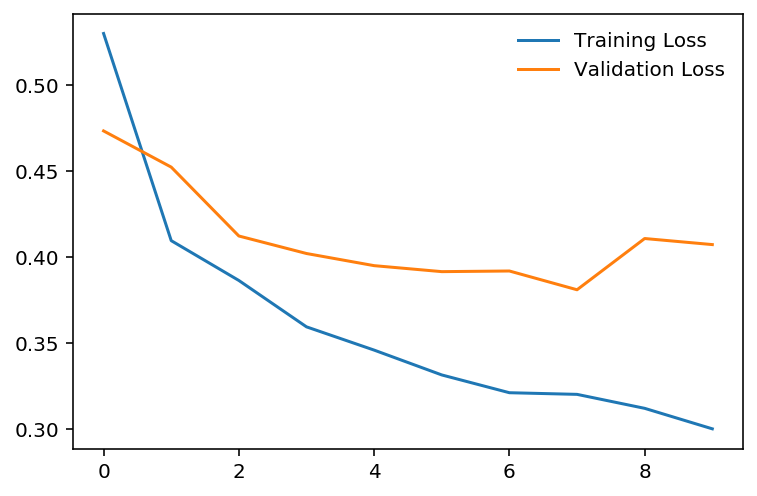

In [53]:
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.legend(frameon=False)
plt.show()

### Applying Dropout

In [54]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        x = F.log_softmax(self.fc4(x), dim=1)
        return x

In [55]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [56]:
epochs = 10
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            model.eval()
            for images, labels in test_loader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_ps, top_class = ps.topk(1, dim=1) 
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        model.train()
        
        train_losses.append(running_loss / len(train_loader))
        test_losses.append(test_loss / len(test_loader))
        
        print("{}\n".format("-" * 50),
              "Epoch : {} / {}\n".format(e + 1, epochs),
              "Training loss : {}\n".format(running_loss / len(train_loader)),
              "Test loss : {}\n".format(test_loss / len(test_loader)),
              "Test Accuracy : {}\n".format(accuracy / len(test_loader)))

--------------------------------------------------
 Epoch : 1 / 10
 Training loss : 0.6541955661989732
 Test loss : 0.5038912296295166
 Test Accuracy : 0.8212579488754272

--------------------------------------------------
 Epoch : 2 / 10
 Training loss : 0.5551801416030062
 Test loss : 0.4848213791847229
 Test Accuracy : 0.8226512670516968

--------------------------------------------------
 Epoch : 3 / 10
 Training loss : 0.5229823443013976
 Test loss : 0.5243468880653381
 Test Accuracy : 0.8238455653190613

--------------------------------------------------
 Epoch : 4 / 10
 Training loss : 0.5100004394997412
 Test loss : 0.4691667854785919
 Test Accuracy : 0.8336982727050781

--------------------------------------------------
 Epoch : 5 / 10
 Training loss : 0.5064440283979943
 Test loss : 0.48964837193489075
 Test Accuracy : 0.8324044346809387

--------------------------------------------------
 Epoch : 6 / 10
 Training loss : 0.49934894799677804
 Test loss : 0.4417262077331543
 Te

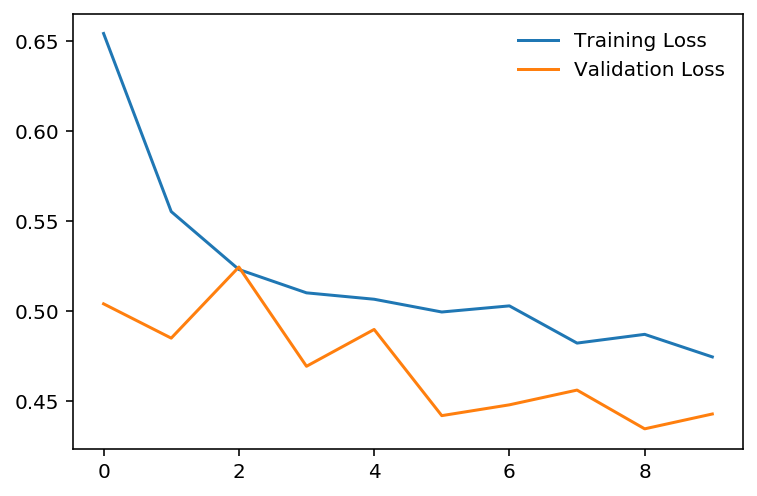

In [57]:
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.legend(frameon=False)
plt.show()

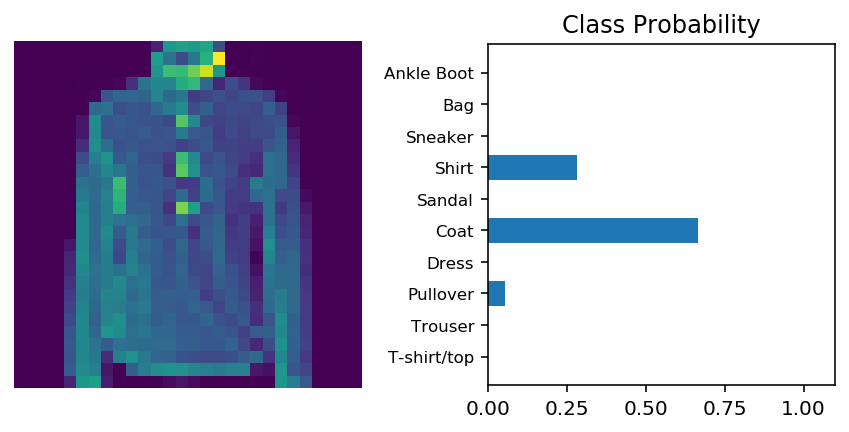

In [59]:
model.eval()
data_iter = iter(test_loader)
images, labels = next(data_iter)
img = images[0]
img = img.view(1, 784)

with torch.no_grad():
    output = model.forward(img)
    
ps = torch.exp(output)

helper.view_classify(img.view(1, 28, 28), ps, version="Fashion")